In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import xml.etree.cElementTree as ET
import matplotlib.pyplot as plt
%matplotlib inline

#try:
#    import xml.etree.cElementTree as ET
#except ImportError:
#    import xml.etree.ElementTree as ET

voc_classes = {
    'Pedestrian'   : 0
}

#### Annotations parsing functions

In [2]:
def findNode(parent, name, debug_name=None, parse=None):
    if debug_name is None:
        debug_name = name

    result = parent.find(name)
    if result is None:
        raise ValueError('missing element \'{}\''.format(debug_name))
    if parse is not None:
        try:
            return parse(result.text)
        except ValueError as e:
            raise ValueError('illegal value for \'{}\': {}'.format(debug_name, e))
    return result

In [3]:
def find_bbox(element):
    class_name = findNode(element, 'name').text
    if class_name not in voc_classes:
        raise ValueError(
                'class name \'{}\' not found in classes: {}'.format(class_name, voc_classes.keys()))

    box = np.zeros((4,))

    bndbox    = findNode(element, 'bndbox')
        
    box[0] = findNode(bndbox, 'xmin', 'bndbox.xmin', parse=float) - 1
    box[1] = findNode(bndbox, 'ymin', 'bndbox.ymin', parse=float) - 1
    box[2] = findNode(bndbox, 'xmax', 'bndbox.xmax', parse=float) - 1
    box[3] = findNode(bndbox, 'ymax', 'bndbox.ymax', parse=float) - 1

    return box

In [4]:
def parse_annotations(xml_root):

    bboxes = np.empty((len(xml_root.findall('object')), 4))
        
    for i, element in enumerate(xml_root.iter('object')):
        try:
            bboxes[i, :] = find_bbox(element)
        except ValueError as e:
            raise ValueError('could not parse object #{}: {}'.format(i, e))
    
    return bboxes

In [5]:
def load_bboxes(data_dir, filename):
    try:
        tree = ET.parse(os.path.join(data_dir, 'Annotations', filename))
        return parse_annotations(tree.getroot())
    except ET.ParseError as e:
        raise ValueError('invalid annotations file: {}: {}'.format(filename, e))
    except ValueError as e:
        raise ValueError('invalid annotations file: {}: {}'.format(filename, e))

#### Scaling functions

In [8]:
def compute_resize_scale(path, min_side=800, max_side=1333):
    """ Compute an image scale such that the image size is constrained to min_side and max_side.

    Args
        min_side: The image's min side will be equal to min_side after resizing.
        max_side: If after resizing the image's max side is above max_side, resize until the max side is equal to max_side.

    Returns
        A resizing scale.
    """
    img_bgr = cv2.imread(path)
    image = np.asarray(img_bgr)
    
    (rows, cols, _) = image.shape

    smallest_side = min(rows, cols)

    # rescale the image so the smallest side is min_side
    scale = min_side / smallest_side

    # check if the largest side is now greater than max_side, which can happen
    # when images have a large aspect ratio
    largest_side = max(rows, cols)
    if largest_side * scale > max_side:
        scale = max_side / largest_side

    return scale

#### Creating Pandas dataframe

In [9]:
df = pd.DataFrame(
    columns=['Dataset', 'Image', 'Width', 'Height', 'Width_Scaled', 'Height_Scaled', 'Aspect_ratio'])

datasets_dir = '../data/laddv4/'
i = 0
for dataset in ['winter', 'summer', 'spring']:
    data_dir = os.path.join(datasets_dir, dataset)
    images_dir = os.path.join(data_dir, 'JPEGImages')
    images = [f.split('.')[0] for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]
    for image in images:
        scale = compute_resize_scale(os.path.join(images_dir, image + '.jpg'))
        bboxes = load_bboxes(data_dir, image + '.' + 'xml')
        for box in bboxes:
            width = box[2]-box[0]
            height = box[3]-box[1]
            aspect_ratio = float(width) / float(height)
            df.loc[i] = [dataset, image, width, height, width * scale, height * scale, aspect_ratio]
            i += 1

In [40]:
df

,Dataset,Image,Width,Height,Width_Scaled,Height_Scaled,Aspect_ratio
0,winter,268,61.0,65.0,16.266667,17.333333,0.938462
1,winter,268,62.0,62.0,16.533333,16.533333,1.000000
2,winter,12,44.0,56.0,11.733333,14.933333,0.785714
3,winter,12,66.0,66.0,17.600000,17.600000,1.000000
4,winter,300,58.0,43.0,15.466667,11.466667,1.348837
...,...,...,...,...,...,...,...
3170,spring,973,86.0,68.0,18.859649,14.912281,1.264706
3171,spring,1008,57.0,109.0,12.500000,23.903509,0.522936
3172,spring,983,88.0,52.0,19.298246,11.403509,1.692308
3173,spring,983,105.0,45.0,23.026316,9.868421,2.333333


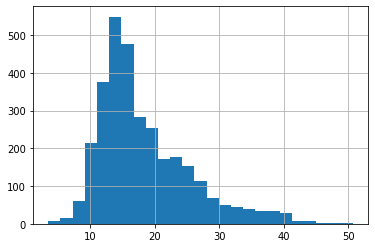

In [43]:
df['Width_Scaled'].hist(bins=25)

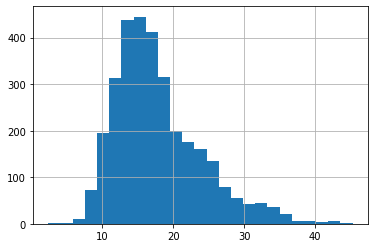

In [44]:
df['Height_Scaled'].hist(bins=25)

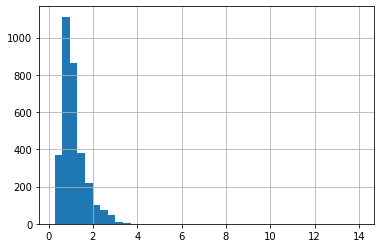

In [10]:
df['Aspect_ratio'].hist(bins=40)

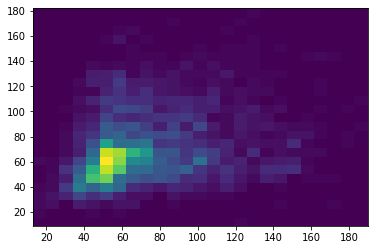

In [11]:
fig = plt.hist2d(df['Width'], df['Height'], bins=25)

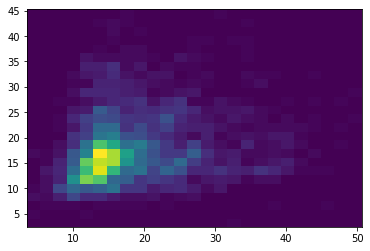

In [53]:
fig = plt.hist2d(df['Width_Scaled'], df['Height_Scaled'], bins=25)